<a href="https://colab.research.google.com/github/meltemyilmaz024/CG_HW1/blob/master/Task_3_Huawei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task-3
- Create a dataframe with following schema:
```
root
|-- content: string (nullable = true) 
|-- label: string (nullable = true) 
|-- sentiment: string (nullable = true)
```


Design a tokenizer for content column and remove stop words, and give descriptive information about obtained content column

## Setup envirment

In [1]:
!pip install pyspark
# Spark SQL
!pip install pyspark[sql]
# pandas API on Spark
!pip install pyspark[pandas_on_spark] plotly  # to plot your data, you can install plotly together.

     |████████████████████████████████| 281.4 MB 27 kB/s 
     |████████████████████████████████| 198 kB 33.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=612524c5905b71cbd14a31838145280b344d6e90275c9a8c5ffcf053b0b5b0f0
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.sql import Row

In [3]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [4]:
from datetime import datetime, date
import pandas as pd
import os
import random
import numpy  as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


## Download and extract dataset


In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

##Load Dataset
First up, let’s load the dataset into Python.



####Loads the IMDb movie reviews sentiment analysis dataset

In [6]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    train_sentiment = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        print(train_path)
        for fname in sorted(os.listdir(train_path)):
            train_sentiment.append(fname.split(".")[0].split("_")[1])
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    test_sentiment = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            test_sentiment.append(fname.split(".")[0].split("_")[1])
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)
    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)
    random.seed(seed)
    random.shuffle(train_sentiment)

    return train_texts+test_texts, np.array(train_labels+test_labels), train_sentiment+test_sentiment
    #return train_texts, np.array(train_labels), train_sentiment, test_texts, np.array(test_labels), test_sentiment
    #return ((train_texts, np.array(train_labels)),
    #    (test_texts, np.array(test_labels)))

In [7]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [8]:
train_texts, train_labels, train_sentiment = load_imdb_sentiment_analysis_dataset('/content', 123)

/content/aclImdb/train/pos
/content/aclImdb/train/neg


### Explore Data

In [9]:
get_num_words_per_sample(sample_texts=train_texts)

173.0

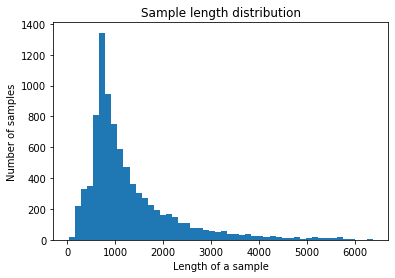

In [10]:
plot_sample_length_distribution(sample_texts=train_texts)

###Create a dataframe with following schema and loaded data

We are using panda Dataframe for more performance

In [11]:
# Calling DataFrame constructor after zipping
# both lists, with columns specified
train_df = pd.DataFrame(list(zip(train_texts, train_labels,train_sentiment)),
               columns =['content', 'label', 'sentiment'])
train_df

,content,label,sentiment
0,Once again Mr. Costner has dragged out a movie...,0,2
1,"First of all, I would like to say that I am a ...",0,3
2,I'm a huge fan of both Emily Watson (Breaking ...,0,4
3,"I was pulled into this movie early on, much to...",0,3
4,This tale of the upper-classes getting their c...,0,4
...,...,...,...
8637,"Writer & director Robert Downey, Sr., a pionee...",0,3
8638,Starting with a tearjerking poem and images of...,0,2
8639,The basic genre is a thriller intercut with an...,0,3
8640,Four things intrigued me as to this film - fir...,0,3


In [12]:
df = spark.createDataFrame(list(zip(train_texts, train_labels, train_sentiment)), schema='content string, label string, sentiment string')
df.printSchema()

root
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [ ]:
#Takes too much time, do not try it Meltem :)
#df.cache()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('english')
stop_word_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
#verimizde bulunan noktalama işaretlerinin temizlenme işlemi
train_df['content'] = train_df['content'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
train_df['content']

0        POSSIBLE SPOILERS<br /><br />The Spy Who Shagg...
1        The long list of big names in this flick inclu...
2        Bette Midler showcases her talents and beauty ...
3        Great movie when I saw it Have to say one of m...
4        Although it's most certainly politically incor...
                               ...                        
49995    I occasionally let my kids watch this garbage ...
49996    When all we have anymore is pretty much realit...
49997    The basic genre is a thriller intercut with an...
49998    Four things intrigued me as to this film - fir...
49999    David Bryce's comments nearby are exceptionall...
Name: content, Length: 50000, dtype: object

In [ ]:
#büyük harflerin küçük harfe çevrilmesi
train_df['content'] = train_df['content'].apply(lambda x: x.lower())
train_df['content']

0        possible spoilers<br /><br />the spy who shagg...
1        the long list of big names in this flick inclu...
2        bette midler showcases her talents and beauty ...
3        great movie when i saw it have to say one of m...
4        although it's most certainly politically incor...
                               ...                        
49995    i occasionally let my kids watch this garbage ...
49996    when all we have anymore is pretty much realit...
49997    the basic genre is a thriller intercut with an...
49998    four things intrigued me as to this film - fir...
49999    david bryce's comments nearby are exceptionall...
Name: content, Length: 50000, dtype: object

In [ ]:
train_df['content'] = train_df['content'].apply(lambda x: x.strip())
train_df['content']

0        possible spoilers<br /><br />the spy who shagg...
1        the long list of big names in this flick inclu...
2        bette midler showcases her talents and beauty ...
3        great movie when i saw it have to say one of m...
4        although it's most certainly politically incor...
                               ...                        
49995    i occasionally let my kids watch this garbage ...
49996    when all we have anymore is pretty much realit...
49997    the basic genre is a thriller intercut with an...
49998    four things intrigued me as to this film - fir...
49999    david bryce's comments nearby are exceptionall...
Name: content, Length: 50000, dtype: object

In [ ]:
train_df['content'] = train_df['content'].str.replace(r'<[^<>]*>', '', regex=True)
train_df['content']

0        possible spoilersthe spy who shagged me is a m...
1        the long list of big names in this flick inclu...
2        bette midler showcases her talents and beauty ...
3        great movie when i saw it have to say one of m...
4        although it's most certainly politically incor...
                               ...                        
49995    i occasionally let my kids watch this garbage ...
49996    when all we have anymore is pretty much realit...
49997    the basic genre is a thriller intercut with an...
49998    four things intrigued me as to this film - fir...
49999    david bryce's comments nearby are exceptionall...
Name: content, Length: 50000, dtype: object

In [ ]:
#cümleler içerisinde bulunan stopword'lerin kaldırılması
def token(values):
    words = nltk.tokenize.word_tokenize(values)
    filtered_words = [word for word in words if word not in stop_word_list]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc

In [ ]:
train_df['content'] = train_df['content'].apply(lambda x: token(x))
train_df['content']

0        possible spoilersthe spy shagged muchly overra...
1        long list big names flick including ubiquitous...
2        bette midler showcases talents beauty diva las...
3        great movie saw say one favorite movies time s...
4        although 's certainly politically incorrect en...
                               ...                        
49995    occasionally let kids watch garbage understand...
49996    anymore pretty much reality tv shows people ma...
49997    basic genre thriller intercut uncomfortable me...
49998    four things intrigued film - firstly stars car...
49999    david bryce 's comments nearby exceptionally w...
Name: content, Length: 50000, dtype: object

##Hyper-parameters
First, we set some hyper-parameters needed for the data preprocessing and model training.

In [ ]:
hparams = {
    "batch_size": 512,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 10000,
    "max_sequence_length": 250
}

Daha sonra verinin içerisinden en çok kullanılan 10000 kelimeye göre bir sözlük oluşturuyoruz. Tabi bu sayıyı belirlemek size kalmış veriye göre değişkenlik gösterebilir.

In [ ]:
tokenizer = text.Tokenizer(num_words=hparams["max_num_words"])
tokenizer.fit_on_texts(train_df['content'])
tokenizer.word_index

{"'s": 1,
 'movie': 2,
 'film': 3,
 "n't": 4,
 'one': 5,
 'like': 6,
 'good': 7,
 'would': 8,
 'even': 9,
 'time': 10,
 'really': 11,
 'see': 12,
 'story': 13,
 'well': 14,
 'much': 15,
 "'": 16,
 'could': 17,
 'get': 18,
 'bad': 19,
 'people': 20,
 'great': 21,
 'also': 22,
 'first': 23,
 'made': 24,
 'make': 25,
 'way': 26,
 'movies': 27,
 'think': 28,
 'characters': 29,
 'character': 30,
 'watch': 31,
 'films': 32,
 'two': 33,
 'many': 34,
 'seen': 35,
 'never': 36,
 'love': 37,
 'plot': 38,
 'acting': 39,
 'life': 40,
 'best': 41,
 'show': 42,
 'little': 43,
 'know': 44,
 'ever': 45,
 'man': 46,
 'better': 47,
 'scene': 48,
 'end': 49,
 'say': 50,
 'still': 51,
 'scenes': 52,
 "'ve": 53,
 'something': 54,
 'go': 55,
 'back': 56,
 "'m": 57,
 'real': 58,
 'watching': 59,
 'thing': 60,
 'actors': 61,
 'old': 62,
 'years': 63,
 'director': 64,
 'funny': 65,
 'though': 66,
 'actually': 67,
 'makes': 68,
 'work': 69,
 'another': 70,
 'find': 71,
 'nothing': 72,
 'look': 73,
 'going': 74,

Burada her bir kelime kullanım sırasına göre numaralandırılıyor. Biliyoruzki cümlelerimizin uzunlukları birbirinden farklı fakat RNN algoritmaları için farklı uzunluklarda olan cümlelerle eğitemiyoruz ki farklı uzunluklarda cümleleri tahmin etmesi olanaksızlaşıyor. Bu nedenle veri setimizde bulunan bütün cümleleri aynı boyuta getirmemiz gerekiyor.

In [ ]:
def prep_text(texts, tokenizer, max_sequence_length):
    # Turns text into into padded sequences.
    return tokenizer.texts_to_sequences(texts)
    #return sequence.pad_sequences(text_sequences, maxlen=max_sequence_length)

x_train_tokens = prep_text(train_df['content'], tokenizer, hparams["max_sequence_length"])

Önce cümlelerimizdeki kelimeleri, yukarıda oluşturmuş olduğumuz sözlükte karşılığında hangi index’te yer alıyorsa onunla değiştiriyoruz.

In [ ]:
num_tokens = [len(tokens) for tokens in x_train_tokens]
num_tokens = np.array(num_tokens)

Daha sonra verimizdeki cümlelerimizin her birinin kelime sayısını alıp birer liste oluşturuyoruz.

In [ ]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)

Sonra oluşturmuş olduğumuz listenin ortalamasını alıp daha sonra standart sapmasını 2 ile çarpıp bir değer elde ediyoruz. Bu değer bize verimizdeki cümlelerimizin dağılımı ile varsa aykırı uzunluğa sahip cümleleri ortalamaya indirgememize sağlayacak.

In [ ]:
#belirlenen bu sayı verinin yüzde kaçını kapsadığına bakılır.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.94544

Buradaki hesapla elde ettiğimiz değerin verimizdeki cümlelerin yüzde kaçını kapsadığını görebiliriz.

In [ ]:
#veriler belirlenen token sayısına göre ayarlanır
x_train_pad = sequence.pad_sequences(x_train_tokens, maxlen=max_tokens)

Daha sonra cümlelerimizi yukarıda elde ettiğimiz değer kadar optimize ediyoruz ve eksik kalan kelime sayısı kadar 0 ekliyoruz. Örnek olarak aşağıdaki çıktıyı inceleyebilirsiniz.

##Build Model

We are now ready to specify the Keras layers. We write a function to create a new model, which we will invoke whenever we wish to train a new model.

In [ ]:
def set_seeds():
  np.random.seed(512)
  tf.compat.v1.set_random_seed(512)
set_seeds()

In [ ]:
from tensorflow.keras import layers

#ardışık bir model
model = keras.Sequential()
#her kelimeye karşılık gelen 50 uzunluğunda bir vektör oluşturulur. (Embedding matrisi)
embedding_size = 50
#matris kelime sayısı ve embedding büyüklüğünde olacak, yani 10bine 50 uzunluğunda. Buna da bir isim veriliyor name değişkeniyle.
model.add(tf.keras.layers.Embedding(input_dim=10000,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='embedding_layer'))
#LSTM layerlerinin eklenmesi
## 32 nöronlu LSTM (16 outputlu , return_sequences=True demek output'un tamamını ver demek)
model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
## 16 nöronlu LSTM (16 outputlu , return_sequences=True demek output'un tamamını ver demek)
model.add(tf.keras.layers.LSTM(units=16, return_sequences=True))
## 8 nöronlu LSTM (8 outputlu , return_sequences=True demek output'un tamamını ver demek)
model.add(tf.keras.layers.LSTM(units=8, return_sequences=True))
## 4 nöronlu LSTM (4 outputlu , return_sequences=False yani default değer, tek bir output verecek)
model.add(tf.keras.layers.LSTM(units=4))
## output layer'ı , görsel olarak gösterilirken dense layer kullanılır.  Tek bir nörondan oluştuğu için 1 yazılır.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#optimizasyon algoritması, 1e-3 = 0.001 demek.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# Create callback for early stopping on validation loss. If the loss does
# not decrease in two consecutive tries, stop training.
callbacks = [tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=5)]
#modeli derlemek, loss fonksiyonu binary_crossentropy -> sadece 2 sınıf ama daha fazla sınıflar için categorical_crossentropy kullanılır.
#metrics -> modelin başarısını görmek için.
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 272, 50)          500000    
                                                                 
 lstm_15 (LSTM)              (None, 272, 32)           10624     
                                                                 
 lstm_16 (LSTM)              (None, 272, 16)           3136      
                                                                 
 lstm_17 (LSTM)              (None, 272, 8)            800       
                                                                 
 lstm_18 (LSTM)              (None, 4)                 208       
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                                 
Total params: 514,773
Trainable params: 514,773
Non-tr

## Train the model


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_pad,train_labels,test_size = 0.2, random_state = 42)

In [ ]:
print("Fit model on training data")
epochs = 40
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    callbacks=callbacks,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
    batch_size=hparams["batch_size"]
)

Fit model on training data
Epoch 1/40
79/79 [==============================] - 11s 73ms/step - loss: 0.6925 - accuracy: 0.5705 - val_loss: 0.6905 - val_accuracy: 0.6722
Epoch 2/40
79/79 [==============================] - 4s 55ms/step - loss: 0.6483 - accuracy: 0.7542 - val_loss: 0.5760 - val_accuracy: 0.8009
Epoch 3/40
79/79 [==============================] - 4s 55ms/step - loss: 0.5276 - accuracy: 0.8442 - val_loss: 0.5003 - val_accuracy: 0.8521
Epoch 4/40
79/79 [==============================] - 4s 54ms/step - loss: 0.4635 - accuracy: 0.8787 - val_loss: 0.4601 - val_accuracy: 0.8605
Epoch 5/40
79/79 [==============================] - 4s 55ms/step - loss: 0.4208 - accuracy: 0.8944 - val_loss: 0.4401 - val_accuracy: 0.8569
Epoch 6/40
79/79 [==============================] - 4s 54ms/step - loss: 0.3878 - accuracy: 0.9068 - val_loss: 0.4189 - val_accuracy: 0.8650
Epoch 7/40
79/79 [==============================] - 4s 54ms/step - loss: 0.3645 - accuracy: 0.9129 - val_loss: 0.4063 - val_ac

## Show performance on chart

In [ ]:
# Print results.
hstr = history.history
print(hstr.keys())
print('Validation accuracy: {accuracy}, loss: {loss}'.format(
        accuracy=hstr['val_accuracy'][-1], loss=hstr['val_loss'][-1]))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Validation accuracy: 0.8611999750137329, loss: 0.38247546553611755


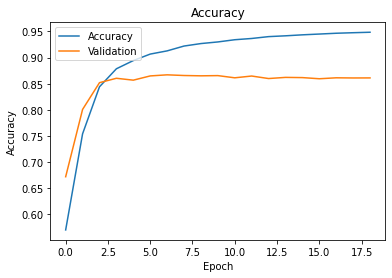

In [ ]:
# summarize history for accuracy
plt.plot(hstr['accuracy'])
plt.plot(hstr['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation'], loc='upper left')
plt.show()

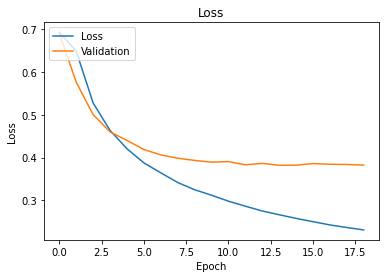

In [ ]:
# summarize history for loss
plt.plot(hstr['loss'])
plt.plot(hstr['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation'], loc='upper left')
plt.show()

##We evaluate the model on the test data via evaluate():


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_val, y_val, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_val[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
79/79 [==============================] - 2s 21ms/step - loss: 0.3825 - accuracy: 0.8612
test loss, test acc: [0.3824754059314728, 0.8611999750137329]
Generate predictions for 3 samples
predictions shape: (3, 1)


In [ ]:
text = "do not like this movie"
text2 = "like this movie"
texts = [text,text2]
tokens = tokenizer.texts_to_sequences(texts)

In [ ]:
tokens_pad = sequence.pad_sequences(tokens,maxlen = max_tokens)
tokens_pad.shape

(2, 272)

In [ ]:
predict_x=model.predict(tokens_pad) 
classes_x=np.argmax(predict_x,axis=1)
print("moralinizin {} olduğunu görüyorum. ".format(classes_x[0]))

moralinizin 0 olduğunu görüyorum. 
